In [6]:
# import tensorflow as tf
import functools
import jax.numpy as jnp
import os
import json
import numpy as np

import jax
from jax.experimental import stax, optimizers
from src import data, model_utils, optim_utils, measurements
from renn.rnn import cells, unroll, network
from renn import utils
import renn

from data_processing import analysis_utils as au
from renn import analysis_utils as renn_au

import tensorflow_datasets as tfds

# from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

import pickle

In [17]:
vocab_file='./data/vocab/ag_news.vocab'
with open(vocab_file, 'r') as f:
    vocab = f.readlines()
vocab_size = len(vocab)

## Load B.O.W. model

In [37]:
def SequenceSum():
    def init_fun(_, input_shape):
        return (input_shape[0], input_shape[2]), ()
    def apply_fun(_, inputs, **kwargs):
        return jnp.sum(inputs, axis=1)
    return init_fun, apply_fun

emb_size = 32

seq_length = 160
num_classes = 3

input_shape = (-1, seq_length)
l2_pen = 0

# Linear model
init_fun, bow_apply_fun = stax.serial(
    renn.embedding(vocab_size, emb_size),
    SequenceSum(),
    stax.Dense(num_classes),
    )

# Initialize
key = jax.random.PRNGKey(0)
output_shape, initial_params = init_fun(key, input_shape)

In [38]:
with open('bow_models/bow_agnews_3class', 'rb') as f:
    bow_params = pickle.load(f)

In [41]:
def delta_logit_bow(vocab_indices, apply_fun, params):
    test_batch = jnp.zeros((1+len(vocab_indices), seq_length), dtype = jnp.int64)
    test_batch = jax.ops.index_update(test_batch, jax.ops.index[1:len(vocab_indices)+1,0], vocab_indices)
    
    logits = apply_fun(params, test_batch)
    return logits[1:] - logits[0]

# Load trained model

In [331]:
data_folder = 'results/ag_news/5_Epoch/classes_3_cell_GRU_eta_0.01_L2_0.01_run_6o2a1mp2/'
with open(os.path.join(data_folder, 'config.json')) as f:
    config = json.load(f)
cell = model_utils.get_cell(config['model']['cell_type'],
                        num_units=config['model']['num_units'])

init_fun, rnn_apply_fun, emb_apply, readout_apply = network.build_rnn(vocab_size,
                                                                  config['model']['emb_size'],
                                                                  cell,
                                                                  num_outputs=config['model']['num_outputs'])
emb_init, emb_apply = renn.embedding(vocab_size, 
                                     config['model']['emb_size'])

network_params = model_utils.load_params(os.path.join(data_folder, 'final_params'))
emb_params, rnn_params, readout_params = network_params

In [332]:
def delta_logit_rnn(inp_nums, rnn_cell, rnn_readout_fun, rnn_emb_fun, rnn_readout_params, rnn_emb_params, rnn_params):
    initial_states = rnn_cell.get_initial_state(rnn_params, batch_size=len(inp_nums))
    initial_logits = rnn_readout_fun(rnn_readout_params, initial_states)
    
    word_input = rnn_emb_fun(rnn_emb_params, inp_nums)
    final_states = rnn_cell.batch_apply(rnn_params, word_input, initial_states)
    final_logits = rnn_readout_fun(rnn_readout_params, final_states)
    
    return final_logits - initial_logits

# Comparison

In [333]:
words_to_try = range(5000)
bow_change = delta_logit_bow(words_to_try, bow_apply_fun, bow_params)
allowed_indices = jnp.where(jnp.max(jnp.abs(bow_change), axis=1) > 1.0)[0]

/usr/local/google/home/ramasesh/VirtualEnvs/dyn/lib/python3.7/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [334]:
len(allowed_indices)

138

[None, None, None, None, None, None]

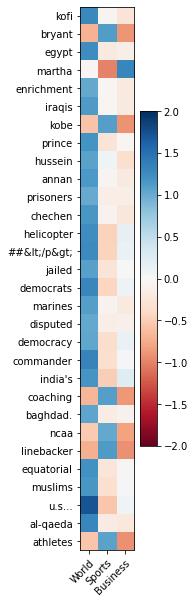

In [335]:
min_word = 91
max_word = 120

f, ax = plt.subplots(figsize=(2,10))
im = ax.imshow(bow_change[jax.ops.index[allowed_indices[jax.ops.index[min_word:max_word + 1]]]], vmin=-2, vmax=2, cmap='RdBu')
ax.set_yticks(np.arange(max_word - min_word+1))
ax.set_yticklabels([vocab[i][:-1] for i in allowed_indices[jax.ops.index[min_word:max_word + 1]]])
ax.set_xticks([0,1,2])
ax.set_xticklabels(['World', 'Sports', 'Business'])
cbar = ax.figure.colorbar(im, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

Text(0, 0.5, 'Frequency')

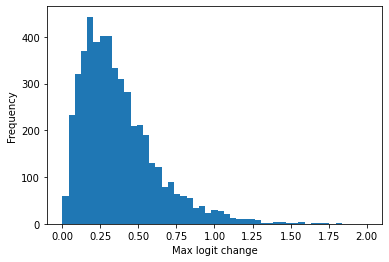

In [336]:
plt.hist(jnp.max(jnp.abs(bow_change), axis=1), bins=np.linspace(0,2, 50))
plt.xlabel('Max logit change')
plt.ylabel('Frequency')

In [337]:
len(allowed_indices)

138

In [338]:
bow_change = delta_logit_bow(allowed_indices, bow_apply_fun, bow_params)

In [339]:
rnn_change = delta_logit_rnn(allowed_indices, cell, readout_apply, emb_apply, readout_params, emb_params, rnn_params)

In [340]:
def theta(vecs1, vecs2):
    dot_products = jnp.diag(jnp.dot(vecs1, vecs2.T))
    magnitudes = jnp.sqrt(jnp.diag(jnp.dot(vecs1, vecs1.T))*jnp.diag(jnp.dot(vecs2, vecs2.T)))
    
    return jnp.arccos(dot_products/magnitudes)

In [341]:
thetas = theta(rnn_change, bow_change)

In [342]:
np.mean(thetas)*180/np.pi

DeviceArray(24.58804, dtype=float32)

Text(0.8, 30, 'Mean: 24.59\ndegrees')

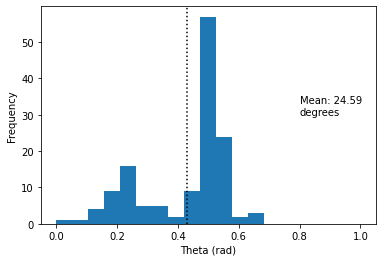

In [343]:
plt.hist(thetas, bins=np.linspace(0,1, 20))
plt.xlabel('Theta (rad)')
plt.ylabel('Frequency')
plt.axvline(np.mean(thetas), linestyle='dotted', color='k')
plt.text(0.8, 30, f'Mean: {np.mean(thetas)*180/np.pi:0.2f}\ndegrees')